In [64]:
# importing libraries.
import pandas as pd
import numpy as np

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import itertools

import base64

import io

Loading Data

In [2]:
# Used breeds.
breeds = ['beagle', 'bernese_mountain_dog', 'doberman', 'labrador_retriever', 'siberian_husky']
# Dictionary with parameters necessary to read img.
kwargs = {
    'labels' : 'inferred',
    'label_mode' : 'categorical',
    'batch_size' : 128,
    'image_size' : (128,128),
    'seed' : 10,
    'validation_split' : 0.3,
    'class_names' : breeds,
}
# Loading img and converting them into a tensorflow dataset
train = tf.keras.utils.image_dataset_from_directory(
    './data/images/',
    subset='training',
    **kwargs
)

test = tf.keras.utils.image_dataset_from_directory(
    './data/images/',
    subset='validation',
    **kwargs
)

Found 926 files belonging to 5 classes.
Using 649 files for training.
Found 926 files belonging to 5 classes.
Using 277 files for validation.


Exploring images in data

In [3]:
# Seeing what i have just obtained.
train

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [4]:
# Taking my first batch of images, a single batch has 32 images.
first_batch = train.take(1)
first_batch

<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [5]:
# Calling 'list' to force the iterator to evaluate.
images, labels = list(first_batch)[0]
# Obtaining the first element in images.
first_img = images[0]
# Looking into red array, how much red is in each pixel.
first_img[:3,:3,0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[90.530945, 86.97748 , 85.92969 ],
       [87.66406 , 86.70819 , 90.23761 ],
       [82.34918 , 82.53516 , 86.4881  ]], dtype=float32)>

In [6]:
# Looking into green array.
first_img[:3,:3,1]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[143.53094, 139.97748, 138.92969],
       [140.66406, 139.70819, 143.23761],
       [135.34918, 135.53516, 139.4881 ]], dtype=float32)>

In [7]:
# Looking into blue array.
first_img[:3,:3,2]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[75.530945, 71.97748 , 70.92969 ],
       [72.66406 , 71.70819 , 75.23761 ],
       [67.34918 , 67.53516 , 71.4881  ]], dtype=float32)>

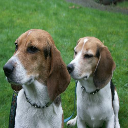

In [8]:
# Displaying the img.
# Converting Tensor to array.
first_img = np.array(first_img).astype('uint8')
Image.fromarray(first_img)

In [9]:
# Checking label corresponding to the previous img.
print(breeds)
print(labels[0])

['beagle', 'bernese_mountain_dog', 'doberman', 'labrador_retriever', 'siberian_husky']
tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)


Training initial CNN.

In [10]:
# Storing img in memory, do not load from disk every time.
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
# Creating first model.
first_model = keras.Sequential([
    # Base.
    layers.Rescaling(1./255),# Rescaling data because pixel intensity is from 0 to 255, neural net works better when those values are instead from 0 to 1.
    layers.Conv2D(filters=16, kernel_size=3,padding='same', activation='relu', input_shape=[128,128,3]), # Scanning img with CNN, generating new features.
    
    # Head.
    # Making predictions with the features obtained by 'Base'.
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(breeds))
])
# Compiling model, so its ready for making predictions.
first_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = first_model.fit(
    train,
    validation_data=test,
    epochs=5,
    verbose=1
)

Epoch 1/5
6/6 [==============================] - 3s 86ms/step - loss: 4.8636 - accuracy: 0.2142 - val_loss: 3.7658 - val_accuracy: 0.1805
Epoch 2/5
6/6 [==============================] - 0s 37ms/step - loss: 4.2159 - accuracy: 0.2234 - val_loss: 3.1456 - val_accuracy: 0.1805
Epoch 3/5
6/6 [==============================] - 0s 37ms/step - loss: 8.1679 - accuracy: 0.2234 - val_loss: 13.1637 - val_accuracy: 0.1805
Epoch 4/5
6/6 [==============================] - 0s 37ms/step - loss: 12.2570 - accuracy: 0.2234 - val_loss: 10.6415 - val_accuracy: 0.1805
Epoch 5/5
6/6 [==============================] - 0s 37ms/step - loss: 9.1637 - accuracy: 0.2234 - val_loss: 7.1263 - val_accuracy: 0.1805


In [12]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 128)               33554560  
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 33,555,653
Trainable params: 33,555,653
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot: >

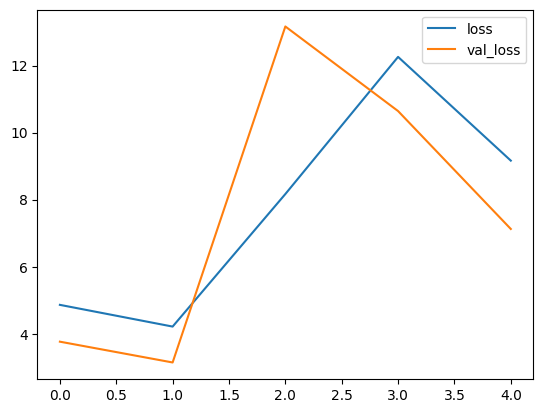

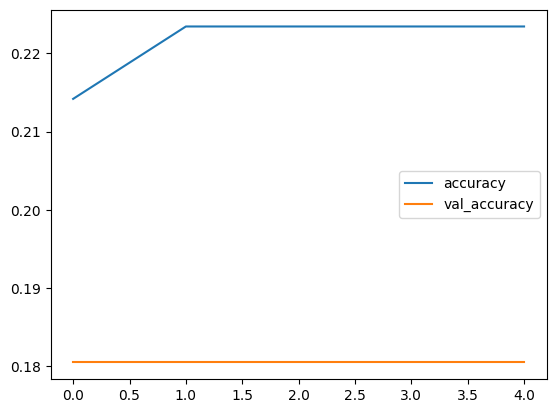

In [13]:
history_frame_1 = pd.DataFrame(history.history)

history_frame_1[['loss', 'val_loss']].plot()
history_frame_1[['accuracy', 'val_accuracy']].plot()

Improving model accuracy

In [14]:
# Function that takes network and epochs as paramers.
#   // and will train the model, returning history DF and trained model.
def train_model (network, epochs=5):
    # Early stopping.
    stop = keras.callbacks.EarlyStopping(
        min_delta=0.001,
        patience=20,
        restore_best_weights=True
    )
    
    model = keras.Sequential(network)
    
    model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )
    
    history = model.fit(
    train,
    validation_data=test,
    epochs=epochs,
    verbose=1,
    callbacks=[stop]
    )
    
    history_frame = pd.DataFrame(history.history)
    return history_frame, model

In [15]:
data_augmentation = keras.Sequential([
    layers.RandomContrast(factor=0.5),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    layers.RandomRotation(factor=0.1, fill_mode='reflect'),
    #layers.RandomWidth(factor=0.2),
    #layers.RandomHeight(factor=0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
])

network = [
    # Data Augmentation.
    data_augmentation,
    
    # Base
    layers.Rescaling(1./255),

    layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(128,128,3)),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Dropout(.2),
    
    # Head.
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(breeds), activation='softmax')
]

full_net = [data_augmentation] + network
history_df, model = train_model(network, epochs=60)

Epoch 1/60
6/6 [==============================] - 2s 94ms/step - loss: 1.7277 - accuracy: 0.2203 - val_loss: 1.5981 - val_accuracy: 0.2599
Epoch 2/60
6/6 [==============================] - 0s 48ms/step - loss: 1.6169 - accuracy: 0.2435 - val_loss: 1.5955 - val_accuracy: 0.2347
Epoch 3/60
6/6 [==============================] - 0s 47ms/step - loss: 1.5995 - accuracy: 0.2357 - val_loss: 1.6001 - val_accuracy: 0.2347
Epoch 4/60
6/6 [==============================] - 0s 48ms/step - loss: 1.5942 - accuracy: 0.2357 - val_loss: 1.5883 - val_accuracy: 0.2347
Epoch 5/60
6/6 [==============================] - 0s 47ms/step - loss: 1.5837 - accuracy: 0.2357 - val_loss: 1.5841 - val_accuracy: 0.2347
Epoch 6/60
6/6 [==============================] - 0s 47ms/step - loss: 1.5694 - accuracy: 0.2604 - val_loss: 1.5879 - val_accuracy: 0.2383
Epoch 7/60
6/6 [==============================] - 0s 48ms/step - loss: 1.5857 - accuracy: 0.2373 - val_loss: 1.5865 - val_accuracy: 0.2563
Epoch 8/60
6/6 [===========

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

<AxesSubplot: >

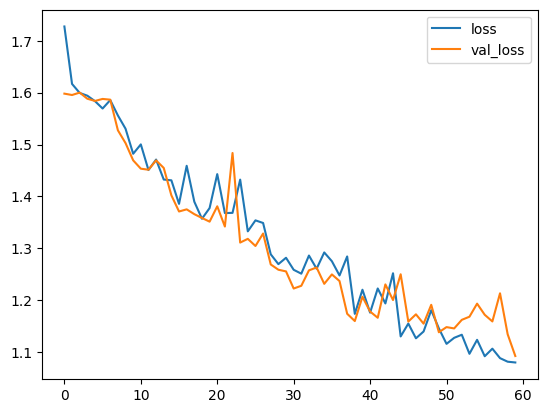

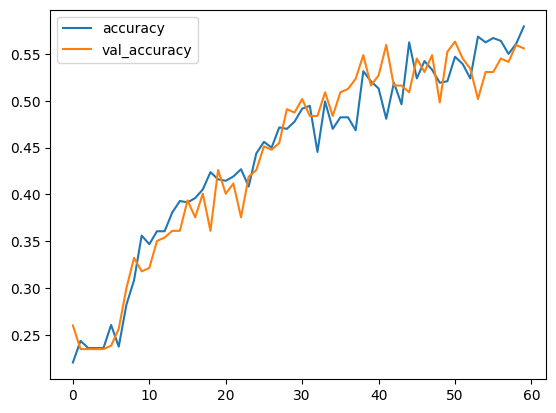

In [17]:
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

Investigating Model error.

In [ ]:
cm = confusion_matrix(test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap="YlGnBu")
plt.xlabel('Valores Predichos')
plt.ylabel('Valores Reales')

In [48]:
# First i will generate predictions.
y_pred = model.predict(test)

# Getting predicted class.
predicted_class = np.argmax(y_pred, axis=1)
predicted_class

array([4, 4, 2, 2, 4, 2, 1, 4, 1, 1, 4, 2, 0, 4, 1, 3, 1, 0, 4, 3, 1, 4,
       3, 0, 0, 0, 4, 4, 1, 1, 4, 1, 4, 0, 3, 1, 2, 1, 4, 4, 1, 1, 3, 0,
       4, 1, 2, 1, 0, 0, 3, 0, 0, 2, 2, 3, 1, 0, 0, 2, 4, 2, 3, 1, 4, 0,
       4, 2, 4, 4, 0, 4, 1, 1, 4, 1, 0, 2, 2, 2, 0, 0, 1, 1, 0, 3, 2, 4,
       1, 4, 1, 2, 0, 3, 0, 1, 1, 4, 3, 3, 0, 0, 2, 4, 2, 0, 1, 1, 1, 3,
       0, 1, 0, 4, 3, 2, 2, 1, 3, 3, 0, 2, 4, 4, 1, 0, 0, 3, 0, 4, 1, 2,
       1, 0, 2, 2, 4, 0, 2, 3, 4, 4, 2, 4, 4, 1, 2, 2, 0, 1, 0, 2, 4, 0,
       0, 0, 0, 0, 4, 0, 1, 1, 4, 4, 1, 4, 4, 0, 4, 3, 2, 2, 2, 2, 2, 3,
       2, 3, 1, 4, 1, 4, 2, 0, 4, 2, 1, 3, 4, 4, 1, 1, 1, 1, 4, 4, 0, 0,
       4, 3, 3, 2, 1, 1, 0, 2, 4, 4, 1, 4, 4, 1, 4, 2, 4, 2, 2, 2, 2, 3,
       0, 4, 4, 1, 2, 4, 1, 4, 2, 4, 2, 3, 2, 4, 4, 3, 1, 2, 4, 0, 0, 1,
       0, 1, 4, 1, 1, 2, 2, 3, 1, 3, 2, 2, 3, 1, 1, 1, 1, 1, 4, 4, 0, 2,
       2, 0, 1, 1, 1, 3, 3, 2, 0, 2, 0, 2, 3], dtype=int64)

In [49]:
# Obtaining actual labels out of test dataset.
actual_labels = np.concatenate([y for x,y in test], axis=0)
actual_labels

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [50]:
actual_class = np.argmax(actual_labels, axis=1)
actual_class

array([4, 0, 2, 0, 4, 2, 1, 4, 3, 1, 4, 2, 0, 3, 1, 0, 1, 0, 4, 3, 1, 0,
       1, 4, 0, 0, 3, 3, 1, 1, 4, 0, 3, 0, 4, 3, 1, 1, 4, 4, 1, 1, 1, 2,
       0, 1, 2, 1, 0, 0, 1, 2, 3, 2, 2, 2, 2, 0, 1, 4, 3, 2, 2, 0, 4, 0,
       4, 2, 4, 0, 1, 4, 1, 1, 3, 1, 0, 2, 3, 2, 0, 0, 4, 2, 0, 2, 2, 4,
       1, 4, 1, 3, 4, 2, 1, 1, 0, 4, 0, 0, 0, 4, 2, 4, 2, 0, 3, 4, 1, 1,
       0, 1, 0, 4, 3, 2, 2, 1, 3, 3, 0, 2, 3, 0, 1, 0, 0, 0, 0, 3, 1, 4,
       1, 0, 1, 1, 2, 3, 2, 4, 3, 4, 1, 4, 3, 1, 2, 2, 3, 2, 1, 3, 3, 0,
       0, 3, 3, 0, 1, 0, 4, 1, 4, 0, 2, 4, 1, 4, 4, 4, 3, 3, 3, 2, 4, 1,
       2, 2, 2, 4, 1, 3, 2, 0, 0, 4, 1, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4,
       0, 4, 4, 4, 3, 4, 0, 3, 4, 4, 1, 1, 4, 1, 2, 2, 4, 3, 3, 3, 0, 4,
       0, 4, 3, 1, 1, 4, 2, 4, 2, 0, 3, 4, 1, 1, 4, 2, 1, 4, 4, 2, 4, 1,
       3, 1, 4, 3, 1, 2, 0, 3, 2, 3, 2, 2, 3, 1, 1, 1, 1, 0, 4, 1, 2, 2,
       2, 4, 1, 1, 4, 4, 3, 2, 0, 2, 3, 2, 3], dtype=int64)

Text(50.5815972222222, 0.5, 'Valores Reales')

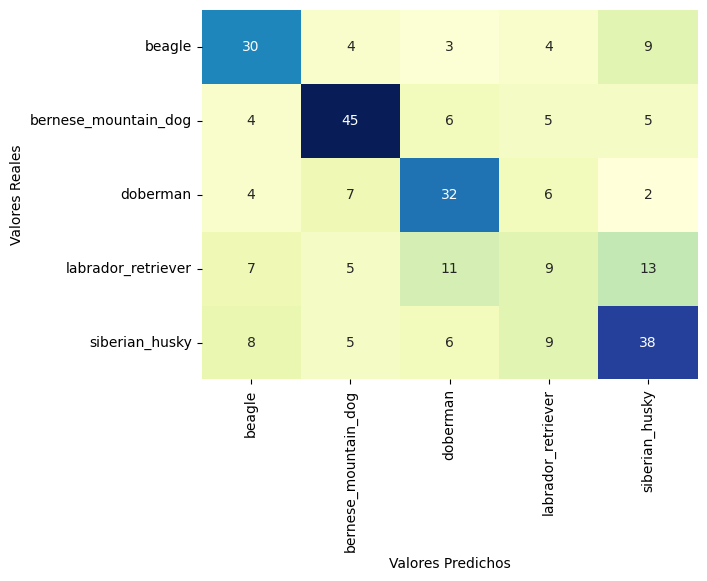

In [55]:
cm = confusion_matrix(actual_class, predicted_class)

cm_df = pd.DataFrame(
    cm,
    index=breeds,
    columns=breeds
)

sns.heatmap(cm_df, annot=True, fmt='d', cbar=False, cmap="YlGnBu")
plt.xlabel('Valores Predichos')
plt.ylabel('Valores Reales')

Now im going to get the image out and see the real value, predicted value and the image itself. 